In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns

import geopandas as gpd

matplotlib.rcParams['font.family'] = 'serif'


In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()

In [3]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities = cities.set_crs(sub_world.crs)
sub_cities_list = list(cities.sjoin(sub_world, how = 'right')['name_left'])[1:]
sub_cities = cities[cities['name'].isin(sub_cities_list)]

In [4]:
def get_ucdp_prio():

    with open(f'/media/simon/Seagate Expansion Drive/Bodies_dfs/PRIO/full_interpl_df_exposure.pkl', 'rb') as file:
        ucdp_prio = pickle.load(file)

    return(ucdp_prio)

ucdp_prio = get_ucdp_prio()

In [5]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_4.pkl', 'rb') as file:
    bodies_df_full = pickle.load(file)

bodies_df = bodies_df_full[(bodies_df_full['distance_days'] == 0) | (bodies_df_full['location_annot'] == 1)].copy() # only locations you are certain of

bodies_df.loc[bodies_df['city'] == 'nan', 'city'] = 'other'

coords = gpd.GeoDataFrame(bodies_df[['longitude_full', 'latitude_full']], geometry=gpd.points_from_xy(bodies_df.longitude_full, bodies_df.latitude_full))
coords = coords.set_crs(sub_world.crs)
#coords = coords.to_crs(sub_world.crs)

bodies_df['coords'] = bodies_df['longitude_full'].astype("string") +'/'+ bodies_df['latitude_full'].astype("string")


In [6]:
list_of_features = ['person_mean', 'uniformed_mean', 'firearm_mean', 'militarized_mean', 'damaged_property_mean', 'mass_protest_mean']
bodies_df_full[list_of_features].mean(axis = 0)

person_mean              2.190914
uniformed_mean           0.330330
firearm_mean             0.067397
militarized_mean         0.129405
damaged_property_mean    0.217529
mass_protest_mean       -0.117367
dtype: float64

In [7]:
bodies_df_full[list_of_features].std(axis = 0)

person_mean              2.152298
uniformed_mean           0.744114
firearm_mean             0.264455
militarized_mean         0.379169
damaged_property_mean    0.572782
mass_protest_mean        0.266437
dtype: float64

In [8]:
for i in list_of_features:
    mask = bodies_df_full[i] >= 1
    r = mask.sum() / mask.shape[0]

    print(f'{i}: {r}')

person_mean: 0.7398809367361422
uniformed_mean: 0.12922832286382632
firearm_mean: 0.02365495308434305
militarized_mean: 0.021887402423318526
damaged_property_mean: 0.11990432885641443
mass_protest_mean: 6.570820301206403e-05


In [9]:
bodies_df_full.shape

(152188, 194)

In [10]:
bodies_df_full[list_of_features][mask].mean(axis = 0)

person_mean              2.600000
uniformed_mean           0.040000
firearm_mean             0.040000
militarized_mean        -0.196388
damaged_property_mean   -0.077985
mass_protest_mean        1.055404
dtype: float64

# In Space:

In [11]:
def get_coords_gpd( feature, bodies_df = bodies_df, sub_world = sub_world):

    sub_df = bodies_df[bodies_df['city'] != 'other']

    if feature == None:
        unique_coords = sub_df.groupby('coords').count()

    else:
        unique_coords = sub_df[sub_df[feature] >= 1].groupby('coords').count()
    
    unique_coords = unique_coords['person_mean'].reset_index() # the feature does not matter here
    unique_coords.rename(columns={'person_mean' : 'images'}, inplace= True)

    unique_coords['l_img'] = np.log(unique_coords['images']) # why?

    unique_coords['longitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,0]
    unique_coords['latitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,1]
    unique_coords.drop('coords', axis=1, inplace=True)

    coords = gpd.GeoDataFrame(unique_coords, geometry=gpd.points_from_xy(unique_coords.longitude_full, unique_coords.latitude_full))
    coords = coords.set_crs(sub_world.crs)

    #city = 'nan' is 33.095579, 44.174977 which is just the centroid of iraq, sp also get rid of those. 
#bodies_df = bodies_df[~(bodies_df['city'] == 'nan')]

    return coords

In [12]:
coords = get_coords_gpd(None)
coords_per = get_coords_gpd('person_mean')
coords_fem = get_coords_gpd('female_mean')
coords_gar = get_coords_gpd('religiousGarmentFemale_mean')
coords_uni = get_coords_gpd('uniformed_mean')
coords_fir = get_coords_gpd('firearm_mean')

In [13]:
coords_mil = get_coords_gpd('militarized_mean')
coords_dam = get_coords_gpd('damaged_property_mean')
coords_pro = get_coords_gpd('mass_protest_mean')

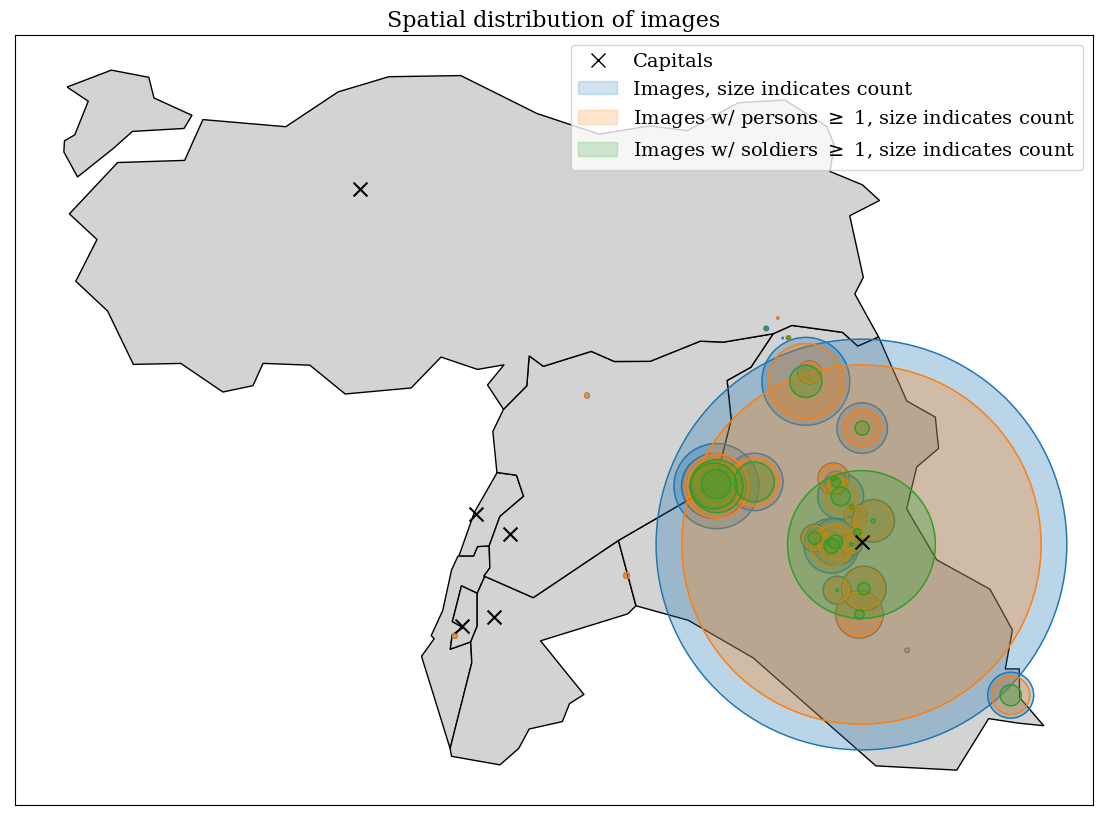

In [14]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], fc = 'none')
coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], alpha = 0.3)

coords_uni.plot(ax=ax, color='C2', marker='o', markersize = coords_uni['images'], fc = 'none')
coords_uni.plot(ax=ax, color='C2', marker='o', markersize = coords_uni['images'], alpha = 0.3)

#coords_fir.plot(ax=ax, color='C3', marker='o', markersize = coords_fir['images'], fc = 'none')
#coords_fir.plot(ax=ax, color='C3', marker='o', markersize = coords_fir['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_per = mpatches.Patch(color='C1', label='Images w/ persons $\geq$ 1, size indicates count', alpha = 0.2)
leg_uni = mpatches.Patch(color='C2', label='Images w/ soldiers $\geq$ 1, size indicates count', alpha = 0.2)
#leg_fir = mpatches.Patch(color='C3', label='Images w/ firearms $\geq$ 1, size indicates count', alpha = 0.2)


ax.legend(handles=[leg_cap, leg_images, leg_per, leg_uni], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map1.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

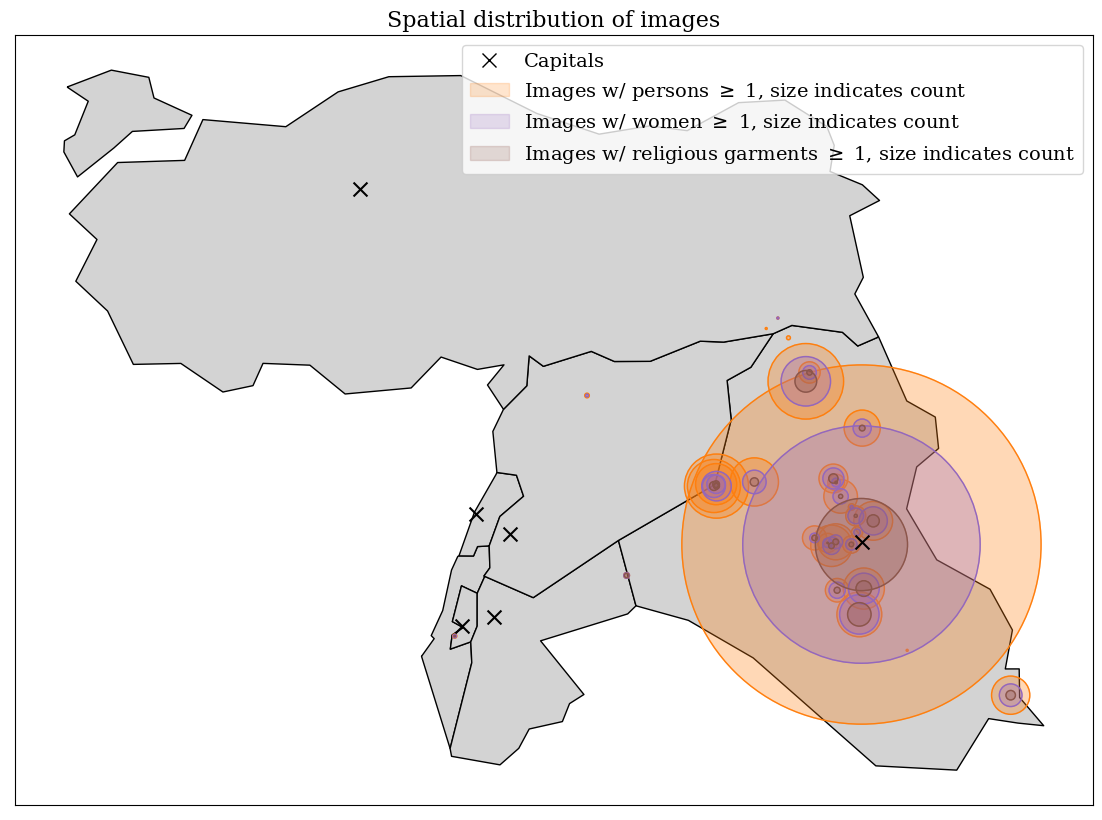

In [15]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

#coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
#coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], fc = 'none')
coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], alpha = 0.3)

coords_fem.plot(ax=ax, color='C4', marker='o', markersize = coords_fem['images'], fc = 'none')
coords_fem.plot(ax=ax, color='C4', marker='o', markersize = coords_fem['images'], alpha = 0.3)

coords_gar.plot(ax=ax, color='C5', marker='o', markersize = coords_gar['images'], fc = 'none')
coords_gar.plot(ax=ax, color='C5', marker='o', markersize = coords_gar['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

#leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_per = mpatches.Patch(color='C1', label='Images w/ persons $\geq$ 1, size indicates count', alpha = 0.2)
leg_fam = mpatches.Patch(color='C4', label='Images w/ women $\geq$ 1, size indicates count', alpha = 0.2)
leg_gar = mpatches.Patch(color='C5', label='Images w/ religious garments $\geq$ 1, size indicates count', alpha = 0.2)


ax.legend(handles=[leg_cap, leg_per, leg_fam, leg_gar], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map2.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [16]:
count_uni = bodies_df[bodies_df['uniformed_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_uni.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_uni, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
1,Kerbala,3,406,0.007389
5,Baqouba,8,938,0.008529
3,Al Taqaddum,5,308,0.016234
4,Abu Ghraib,6,251,0.023904
7,Al-Awja,14,494,0.028340
10,Najaf,47,1160,0.040517
11,Hilla,77,1028,0.074903
15,Habbaniyah,117,1558,0.075096
14,Kirkuk,104,1325,0.078491
13,Falluja,100,1149,0.087032


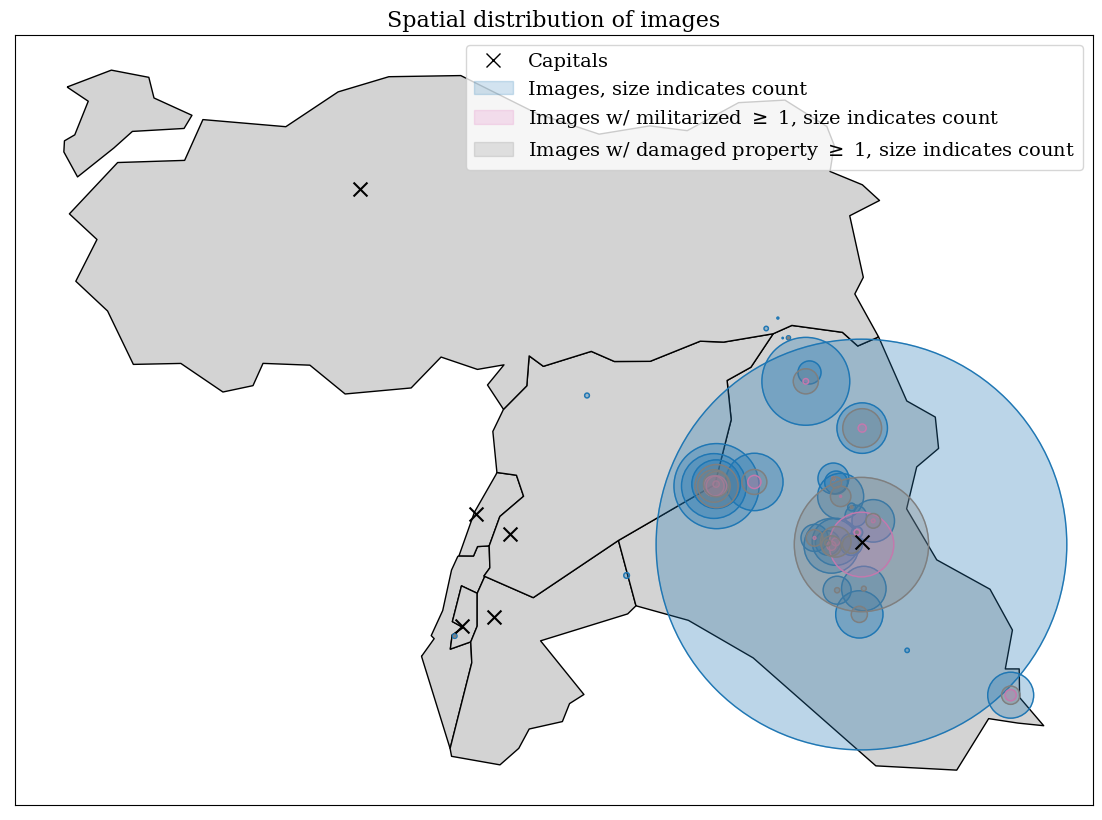

In [17]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_mil.plot(ax=ax, color='C6', marker='o', markersize = coords_mil['images'], fc = 'none')
coords_mil.plot(ax=ax, color='C6', marker='o', markersize = coords_mil['images'], alpha = 0.3)

coords_dam.plot(ax=ax, color='C7', marker='o', markersize = coords_dam['images'], fc = 'none')
coords_dam.plot(ax=ax, color='C7', marker='o', markersize = coords_dam['images'], alpha = 0.3)

#coords_pro.plot(ax=ax, color='C8', marker='o', markersize = coords_pro['images'], fc = 'none')
#coords_pro.plot(ax=ax, color='C8', marker='o', markersize = coords_pro['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_mil = mpatches.Patch(color='C6', label='Images w/ militarized $\geq$ 1, size indicates count', alpha = 0.2)
leg_dam = mpatches.Patch(color='C7', label='Images w/ damaged property $\geq$ 1, size indicates count', alpha = 0.2)
#leg_pro = mpatches.Patch(color='C8', label='Images w/ protest $\geq$ 1, size indicates count', alpha = 0.2)


ax.legend(handles=[leg_cap, leg_images, leg_mil, leg_dam], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map3.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

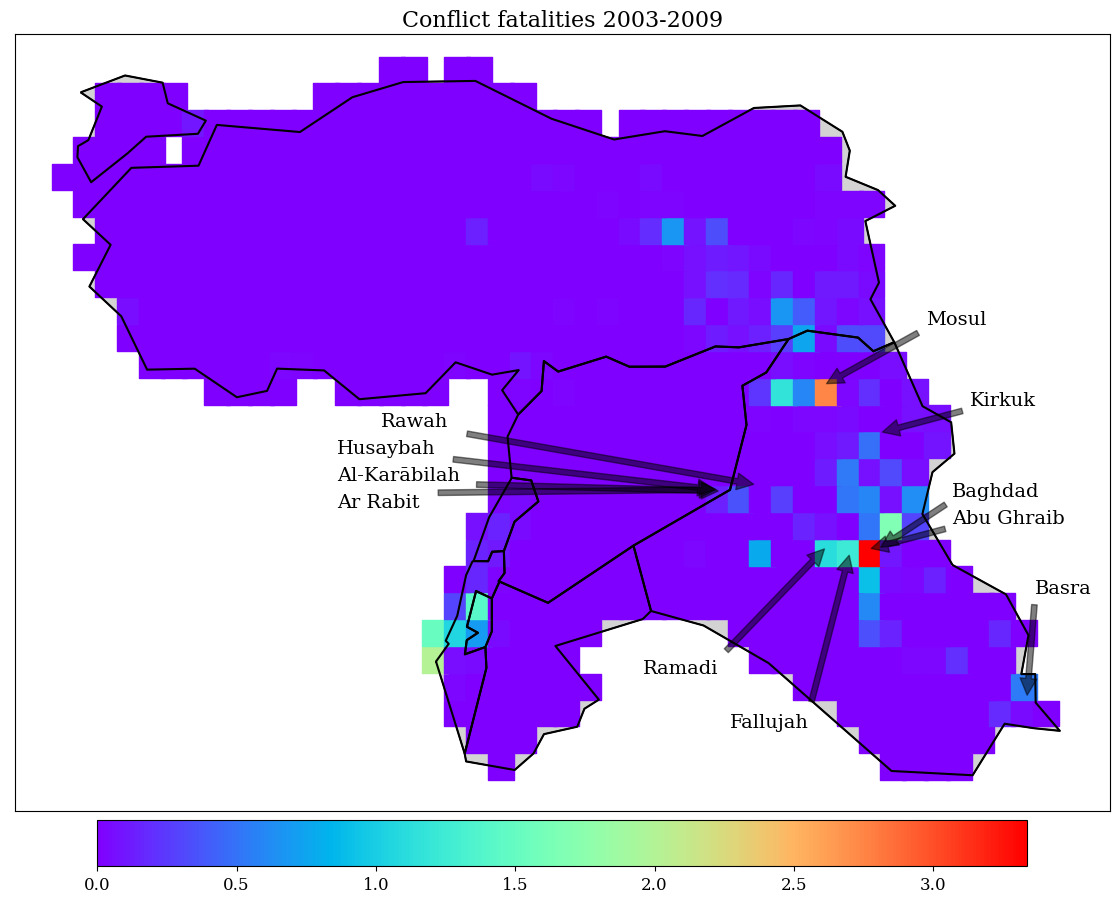

In [18]:
def city_coord(city):
    x = bodies_df.loc[bodies_df['city'] == city, 'longitude_full'].unique().item()
    y = bodies_df.loc[bodies_df['city'] == city, 'latitude_full'].unique().item()

    return(x,y)

# ---------------------
coords_dam_ratio = pd.merge(coords_dam,coords, on = ['longitude_full', 'latitude_full', 'geometry'], how = 'left')
coords_dam_ratio['ratio'] = coords_dam_ratio['images_x'] / coords_dam_ratio['images_y'] 
# ------------------

years = sorted(bodies_df['year'].unique())[1:]

sub_up = ucdp_prio.loc[ucdp_prio['year'].isin(years) ,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()


ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 12))
scatter = ax.scatter(sub_up['xcoord'], sub_up['ycoord'], marker = 's', s = 350, c = sub_up['log_best'], cmap = 'rainbow', alpha = 1)
cbar = plt.colorbar(scatter, location = 'bottom', shrink = 0.8, pad  = 0.01, drawedges = False) # , label= 'log(best+1)'
cbar.ax.tick_params(labelsize=12)
cbar.ax.tick_params(labelsize=12)


sub_world.boundary.plot(ax = ax, color = 'black' , figsize=(15, 10))
#sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

#coords_dam_ratio.plot(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, fc = 'none', linewidth=2)
#coords_dam_ratio.(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, alpha = 0.2)

ax.annotate('Basra', xy=(city_coord('Basra')), xytext=(48, 32.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Mosul', xy=(city_coord('Mosul')), xytext=(45.5, 37.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Kirkuk', xy=(city_coord('Kirkuk')), xytext=(46.5, 36), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Baghdad', xy=(city_coord('Baghdad')), xytext=(46.1, 34.3), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Abu Ghraib', xy=(city_coord('Abu Ghraib')), xytext=(46.1, 33.8), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Fallujah', xy=(city_coord('Falluja')), xytext=(41, 30), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ramadi', xy=(city_coord('Ramadi')), xytext=(39, 31), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ar Rabit', xy=(city_coord('Ar Rabit')), xytext=(32, 34.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Al-Karābilah', xy=(city_coord('Karabilah')), xytext=(32, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Husaybah', xy=(city_coord('Husaybah')), xytext=(32, 35.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Rawah', xy=(city_coord('Rawah')), xytext=(33, 35.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)


plt.title('Conflict fatalities 2003-2009', fontsize = 16)

plt.xticks([])
plt.yticks([])


fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map4.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

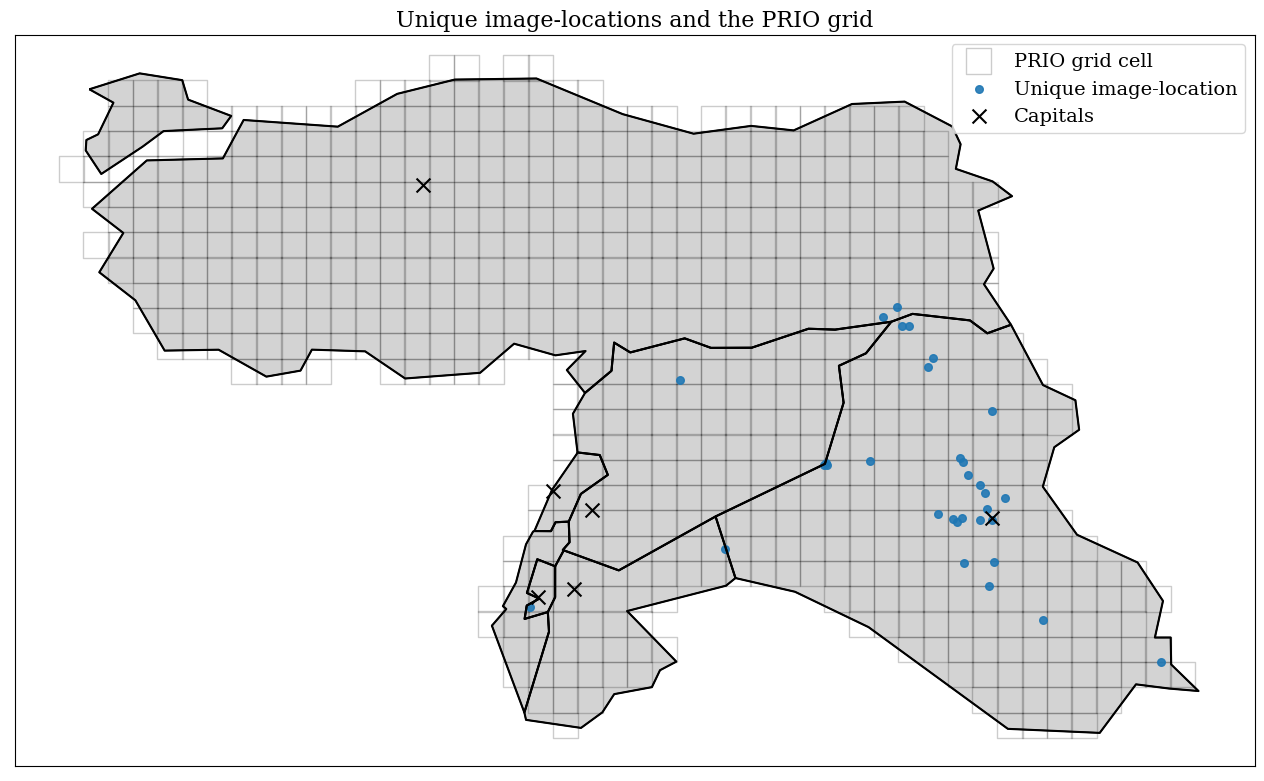

In [19]:
def city_coord(city):
    x = bodies_df.loc[bodies_df['city'] == city, 'longitude_full'].unique().item()
    y = bodies_df.loc[bodies_df['city'] == city, 'latitude_full'].unique().item()

    return(x,y)

# ---------------------
coords_dam_ratio = pd.merge(coords_dam,coords, on = ['longitude_full', 'latitude_full', 'geometry'], how = 'left')
coords_dam_ratio['ratio'] = coords_dam_ratio['images_x'] / coords_dam_ratio['images_y'] 
# ------------------

years = sorted(bodies_df['year'].unique())[1:]

sub_up = ucdp_prio.loc[ucdp_prio['year'].isin(years) ,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()


ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize= [16,9.5], aspect = None)

scatter = ax.scatter(sub_up['xcoord'], sub_up['ycoord'], marker = 's', s = 335, color = 'black', fc = 'none', alpha = 0.2, label = 'PRIO grid cell')

#coords.plot(ax=ax, color='red', marker='x', markersize = coords['images'], fc = 'none', aspect = None)
coords.plot(ax=ax, color='C0', marker='o', markersize = 30, alpha = 0.9, aspect = None, label = 'Unique image-location')


sub_world.boundary.plot(ax = ax, color = 'black' , figsize=[16,9.5], aspect = None)
sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100, aspect = None, label = 'Capitals')

plt.title('Unique image-locations and the PRIO grid', fontsize = 16)

plt.xticks([])
plt.yticks([])

plt.legend(fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map0.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

# Ratios tables

In [20]:
count_mil = bodies_df[bodies_df['militarized_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_mil.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_mil, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
0,Samarra,2,1100,0.001818
4,Mosul,16,4004,0.003996
5,other,16,2812,0.005690
3,Baqouba,7,938,0.007463
1,Ramadi,4,380,0.010526
2,Al-Awja,6,494,0.012146
7,Ar Rabit,21,1225,0.017143
15,Baghdad,2167,87436,0.024784
9,Kirkuk,34,1325,0.025660
10,Habbaniyah,43,1558,0.027599


In [21]:
count_dam = bodies_df[bodies_df['damaged_property_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_dam.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_dam, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
5,Hilla,12,1028,0.011673
4,Al-Awja,6,494,0.012146
0,Taji,2,65,0.030769
6,Kerbala,14,406,0.034483
7,Al Taqaddum,18,308,0.058442
17,Mosul,328,4004,0.081918
3,Balad,3,32,0.093750
24,Baghdad,9358,87436,0.107027
10,Najaf,136,1160,0.117241
9,Baqouba,112,938,0.119403


tjek if this the places with no women are bases. ANd what about the one with same amount of women an persons?

# Temporal

In [22]:
cities = bodies_df['city'].unique()

bodies_df = bodies_df.loc[bodies_df['year'] >= 2003, : ]

unique_months  = bodies_df.groupby(['month_id', 'city']).count()
unique_months = unique_months.reindex(pd.MultiIndex.from_product([unique_months.index.levels[0], cities], names=['month_id', 'city']), fill_value = 0)['person_mean']
unique_months = unique_months.reset_index()
unique_months.rename(columns={'person_mean' : 'all'}, inplace= True)

#months_merge = unique_months

In [23]:
# all images with persons on
unique_months_per = bodies_df[bodies_df['person_mean'] >= 1].groupby(['month_id', 'city']).count()
unique_months_per = unique_months_per.reindex(pd.MultiIndex.from_product([unique_months_per.index.levels[0], cities], names=['month_id', 'city']), fill_value = 0)['person_mean']
unique_months_per = unique_months_per.reset_index()
unique_months_per.rename(columns={'person_mean' : 'persons'}, inplace= True)

# all images with uniforms on
unique_months_uni = bodies_df[bodies_df['uniformed_mean'] >= 1].groupby(['month_id', 'city']).count() 
unique_months_uni = unique_months_uni.reindex(pd.MultiIndex.from_product([unique_months_uni.index.levels[0], cities], names=['month_id', 'city']), fill_value = 0)['person_mean']
unique_months_uni = unique_months_uni.reset_index()
unique_months_uni.rename(columns={'person_mean' : 'uniformed'}, inplace= True)


# all images with uniforms on
unique_months_dam = bodies_df[bodies_df['damaged_property_mean'] >= 1].groupby(['month_id', 'city']).count() 
unique_months_dam = unique_months_dam.reindex(pd.MultiIndex.from_product([unique_months_dam.index.levels[0], cities], names=['month_id', 'city']), fill_value = 0)['person_mean']
unique_months_dam = unique_months_dam.reset_index()
unique_months_dam.rename(columns={'person_mean' : 'damaged_property'}, inplace= True)

months_merge = unique_months.merge(unique_months_per, how = 'outer', on = ['month_id', 'city'])
months_merge = months_merge.merge(unique_months_uni, how = 'outer', on = ['month_id', 'city'])
months_merge = months_merge.merge(unique_months_dam, how = 'outer', on = ['month_id', 'city'])

#months_merge.fillna(0, inplace = True)

In [24]:
lwd = [294, 299, 300] # likely wrong dates/months. 
months_merge = months_merge[~months_merge['month_id'].isin(lwd)] # removes 99 obs,

In [25]:
def plot_temporal_cities(feature, months_merge = months_merge):

    colors  = sns.color_palette("hls", 12)

    fig, ax = plt.subplots(figsize=[15,8])

    x = months_merge['month_id'].unique()

    # x1 = months_merge.loc[months_merge['city'] == 'Baghdad','month_id'].reindex(months_merge.index, fill_value=0)
    # x2 = months_merge.loc[months_merge['city'] == 'Falluja','month_id'].reindex(months_merge.index, fill_value=0)
    #x3 = months_merge.loc[months_merge['city'] == 'Ramadi','month_id']

    selected = ['Baghdad','Abu Ghraib', 'Fallujah', 'Husaybah', 'Rawah', 'Karabilah', 'Ar Rabit', 'Ramadi', 'Mosul', 'Basra', 'Kirkuk']

    y1 = months_merge.loc[months_merge['city'] == 'Baghdad',feature].values
    y2 = months_merge.loc[months_merge['city'] == 'Falluja',feature].values
    y3 = months_merge.loc[months_merge['city'] == 'Ramadi',feature].values
    y4 = months_merge.loc[months_merge['city'] == 'Rawah',feature].values
    y5 = months_merge.loc[months_merge['city'] == 'Abu Ghraib',feature].values
    y6 = months_merge.loc[months_merge['city'] == 'Husaybah',feature].values
    y7 = months_merge.loc[months_merge['city'] == 'Ar Rabit',feature].values
    y8 = months_merge.loc[months_merge['city'] == 'Karabilah',feature].values
    y9 = months_merge.loc[months_merge['city'] == 'Mosul',feature].values
    y10 = months_merge.loc[months_merge['city'] == 'Basra',feature].values
    y11 = months_merge.loc[months_merge['city'] == 'Kirkuk',feature].values
    y12 = months_merge.loc[~months_merge['city'].isin(selected), ['month_id', 'all']].groupby('month_id').sum()['all'].values


    alpha = 0.8

    ax.bar(x, y1, width = 1, alpha = alpha, label = 'Baghdad', color = colors[0])
    ax.bar(x, y2, bottom= y1,  width = 1, alpha = alpha, label = 'Fallujah', color = colors[1])
    ax.bar(x, y3, bottom= y1+y2,  width = 1, alpha = alpha, label = 'Ramadi', color = colors[2])
    ax.bar(x, y4, bottom= y1+y2+y3,  width = 1, alpha = alpha, label = 'Rawah', color = colors[3])
    ax.bar(x, y5, bottom= y1+y2+y3+y4,  width = 1, alpha = alpha, label = 'Abu Ghraib', color = colors[4])
    ax.bar(x, y6, bottom= y1+y2+y3+y4+y5,  width = 1, alpha = alpha, label = 'Husaybah', color = colors[5])
    ax.bar(x, y7, bottom= y1+y2+y3+y4+y5+y6,  width = 1, alpha = alpha, label = 'Ar Rabit', color = colors[6])
    ax.bar(x, y8, bottom= y1+y2+y3+y4+y5+y6+y7,  width = 1, alpha = alpha, label = 'Al-Karābilah', color = colors[7])
    ax.bar(x, y9, bottom= y1+y2+y3+y4+y5+y6+y7+y8,  width = 1, alpha = alpha, label = 'Mosul', color = colors[8])
    ax.bar(x, y10, bottom= y1+y2+y3+y4+y5+y6+y7+y8+y9,  width = 1, alpha = alpha, label = 'Basra', color = colors[9])
    ax.bar(x, y11, bottom= y1+y2+y3+y4+y5+y6+y7+y8+y9+y10,  width = 1, alpha = alpha, label = 'Kirkuk', color = colors[10])
    ax.bar(x, y12, bottom= y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11,  width = 1, alpha = alpha, label = 'Other', color = 'gray')

    #ax.annotate('Abu Ghraib', xy=(280,  np.nanmax(y1+y5)), xytext=(282, 2800), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
    #ax.annotate('Western Anbar Province', xy=(311, np.nanmax(y6+y7+y8)), xytext=(282, 2800), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
    #ax.annotate('Abu Ghraib', xy=(280, 2500), xytext=(282, 2800), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)


    if feature == 'all':
        plt.title(f'Temporal distribution of images across locations', fontsize = 16)
        ax.annotate('Baghdad is captured \n by U.S. forces \n April. 2003', xy=(280, 3000), xytext=(284, 3900),
                    arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')

        ax.annotate('Operation \n Phantom Fury, \n Nov. 2004', xy=(299, 0), xytext=(297, 2000),
                     arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')


        ax.annotate('Operation \n Steel Curtain \n Nov. 2005', xy=(311, np.nanmax(y6+y7+y8)*1.1), xytext=(313, np.nanmax(y6+y7+y8)*1.45), 
                    arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')

        

    else:
        plt.title(f'Temporal distribution of images across locations \n w/ {feature.replace("_", " ")} $\geq$ 1', fontsize = 16)



    #plt.xlabel('Month ID', fontsize = 14)
    plt.ylabel('Images, count', fontsize = 14)


    ticks_number = np.arange(280, 370, 10)
    ticks_name = ['April \n 2003', 'Feburary \n 2004', 'December \n 2004', 'October \n 2005', 'August \n 2006', 'June \n 2007', 'April \n 2008', 'Feburary \n 2009', 'December \n 2009']
    
    plt.xticks(ticks_number, ticks_name, fontsize = 14)
    plt.yticks(fontsize = 14)

    plt.ylim(0,np.nanmax(y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11+y12)*1.1)

    plt.legend()



    fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/trend0.png'
    plt.savefig(fig_path, bbox_inches="tight")

    plt.show()

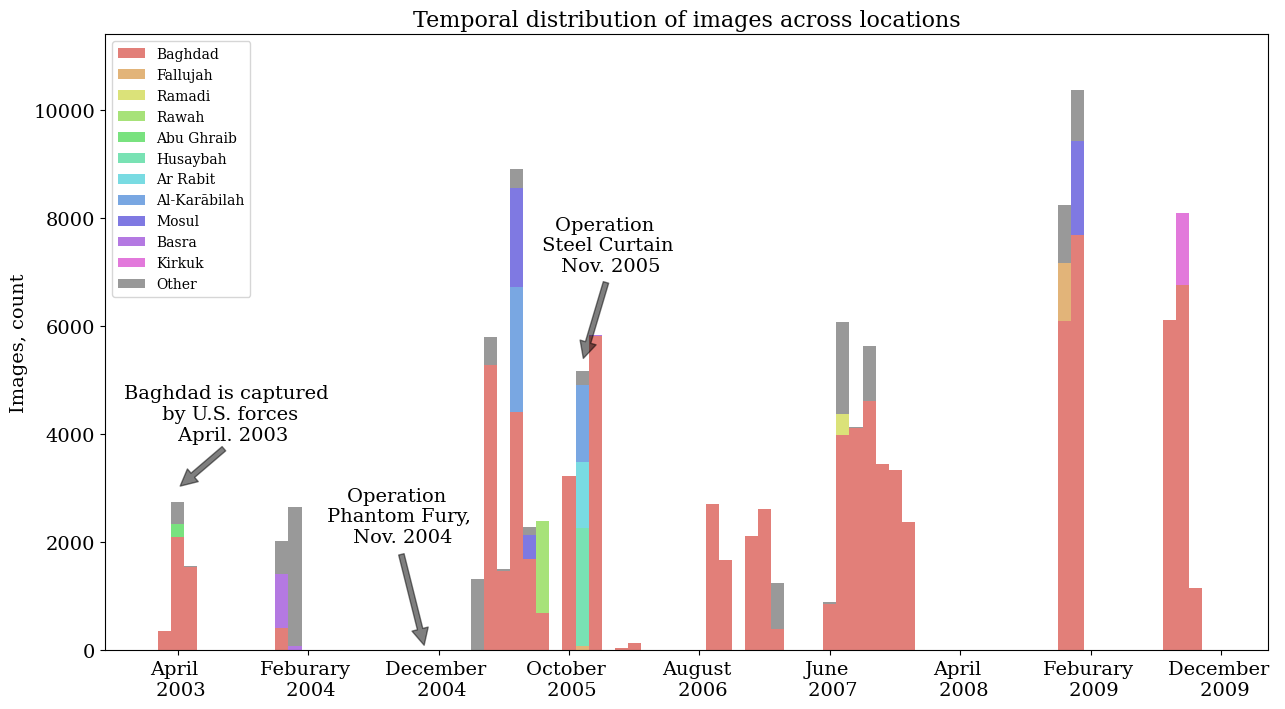

In [26]:
plot_temporal_cities('all')

In [31]:
def plot_temporal_features(months_merge = months_merge):


    fig, ax = plt.subplots(figsize=[15,8])

    month_df = months_merge.groupby('month_id').sum(numeric_only = True).reset_index()

    ax.bar(month_df['month_id'], month_df['all'], width = 1, alpha = 1, label = 'total number of images')
    ax.bar(month_df['month_id'], month_df['persons'],  width = 0.7, alpha = 1, label = 'number of images w/ persons')
    ax.bar(month_df['month_id'], month_df['uniformed'],  width = 0.4, alpha = 1,  label = 'number of images w/ uniformed personelle')

    ax.annotate('Operation \n Steel Curtain \n Nov. 2005', xy=(311, 5050), xytext=(313, 6500), 
                        arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')


    # ax.annotate('Rawah \n Aug. 2005', xy=(308, 2400), xytext=(298, 3500), 
    #                     arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')

    plt.hlines(month_df.loc[month_df['month_id'] == 311, 'uniformed'].item(), month_df['month_id'].min(), month_df['month_id'].max(), 
            linestyle = 'dashed', color = 'darkred', alpha = 0.6, label = 'images w/ uniforms under \n Operation Steel Curtain')

    plt.title('Temporal distribution of selected motifs', fontsize = 16)

    #plt.xlabel('Month ID', fontsize = 14)
    plt.ylabel('Images, count', fontsize = 14)

    ticks_number = np.arange(280, 370, 10)
    ticks_name = ['April \n 2003', 'Feburary \n 2004', 'December \n 2004', 'October \n 2005', 'August \n 2006', 'June \n 2007', 'April \n 2008', 'Feburary \n 2009', 'December \n 2009']
    
    plt.xticks(ticks_number, ticks_name, fontsize = 14)
    plt.yticks(fontsize = 14)

    plt.legend()


    fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/trend1.png'
    plt.savefig(fig_path, bbox_inches="tight")

    plt.show()

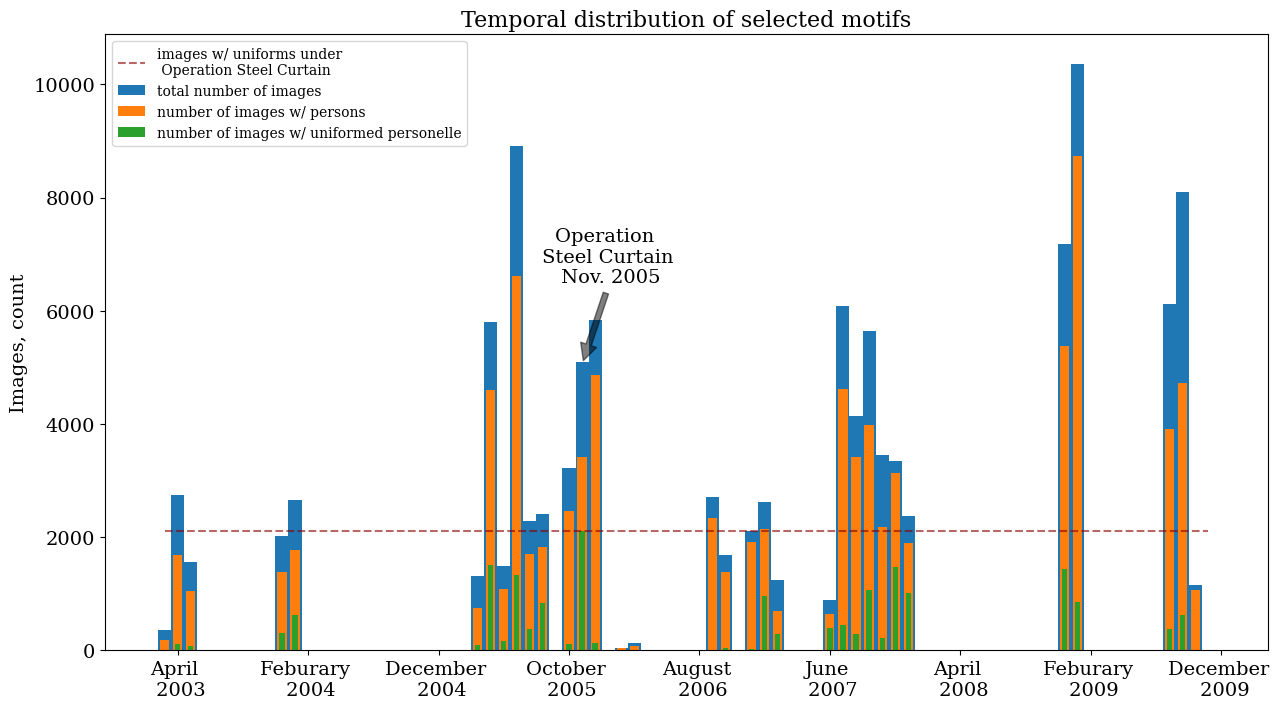

In [32]:
plot_temporal_features()